In [1]:
import numpy as np
import pandas as pd

In [2]:
import pandas as pd

DB_URL = 'onad.cbjjamtlar2t.ap-northeast-2.rds.amazonaws.com'
DB_USER = 'onad'
DB_PASSWORD = 'rkdghktn12'
DB_DATABASE = 'onad'
DB_CHARSET = 'utf8mb4'
DB_LOGFLAG  = 'False'
DB_PORT = 3306

db_url = "mysql+pymysql://%s:%s@%s:%s/%s?charset=%s" % (
    DB_USER, DB_PASSWORD,
    DB_URL, DB_PORT,
    DB_DATABASE, DB_CHARSET
)

def data_from_sql_twitchchat(streamer, target_date):
    query = """
        select * from twitch_chat where streamer_name = "%s" and broad_date ="%s"
    """% (streamer, target_date)

    return pd.read_sql_query(query, db_url)

In [100]:
streamer = "rhdgurwns"
target_date = "2019-01-06"
df = data_from_sql_twitchchat(streamer, target_date)

In [167]:
chat_df = df.copy()
chat_df.head(2)

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
0,18350970,rhdgurwns,2019-01-06,<%친애하는강현님께 (wls4429)>,08:59:49,혁하
1,18350971,rhdgurwns,2019-01-06,<junsu3680>,09:00:21,혁ㅎ


In [168]:
# 인덱스 변경
chat_df['chat_time'] = chat_df['chat_time'].apply(lambda x : target_date + " " + x)
chat_df.index = pd.to_datetime(chat_df['chat_time'])

In [169]:
# 필요없는 컬럼 제거
del chat_df['chat_id']
del chat_df['streamer_name']
del chat_df['broad_date']

In [170]:
start_time = chat_df[chat_df['chat_contents'] == "혁하"].index[5]

In [171]:
chat_df['stream_time'] = chat_df.index
chat_df['stream_time'] = chat_df['stream_time'].apply(lambda x : x - start_time)
chat_df = chat_df[chat_df.stream_time >= "00:00:00"]

In [172]:
chat_df.head()

,chatterer,chat_time,chat_contents,stream_time
chat_time,,,,
2019-01-06 09:00:34,<LURV>,2019-01-06 09:00:34,<3 <3 <3,00:00:00
2019-01-06 09:00:34,<소중이 (gasasung)>,2019-01-06 09:00:34,혁하,00:00:00
2019-01-06 09:00:34,<서새붐 (dmltmf123)>,2019-01-06 09:00:34,G,00:00:00
2019-01-06 09:00:34,<mok05177>,2019-01-06 09:00:34,혁하,00:00:00
2019-01-06 09:00:36,<허로빈 (heorobin)>,2019-01-06 09:00:36,공하,00:00:02


In [173]:
anal_df = chat_df.pivot_table(index=chat_df.index, values='chatterer', aggfunc=len).loc[:, ['chatterer']]
anal_df.columns = ['cnt_chat']

word_list = ['ㅋ', 'ㄵ', '오', '와', '유하']

for word in word_list:
    target_word = "cnt_" + word
    chat_df[target_word] =  chat_df.chat_contents.apply(lambda x : x.count(word))
    anal_df[target_word] = chat_df.pivot_table(index=chat_df.index, values=target_word, aggfunc=sum).loc[:, target_word]

anal_df['cnt_chat'].unique().mean(), anal_df['cnt_chat'].mean()


(14.130434782608695, 2.77320746235109)

In [174]:
anal_df.head()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
chat_time,,,,,,
2019-01-06 09:00:34,4,0,0,0,0,0
2019-01-06 09:00:36,1,0,0,0,0,0
2019-01-06 09:00:41,1,0,0,0,0,0
2019-01-06 09:00:45,2,0,0,0,0,0
2019-01-06 09:00:46,1,0,0,0,0,0


### 스케일링작업

In [175]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x_train = sc.fit_transform(anal_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [176]:
x_train

array([[0.06818182, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

### 공혁준 머신러닝 모델 가져오기

In [177]:
import pickle

model_url = "../../ml_model/rhdgurwns_GaussianNB.pickle"
with open(model_url, 'rb') as fp:
    model = pickle.load(fp)

In [178]:
pre = model.predict(x_train)
anal_df['predict'] = pre

In [179]:
yes_data = anal_df[anal_df['predict'] == 1]
no_data = anal_df[anal_df['predict'] == 0]

In [180]:
yes_data.shape

(1936, 7)

In [181]:
no_data.shape

(15860, 7)

In [182]:
yes_data['cnt_chat'].unique()

array([ 1,  3,  4,  8,  2,  9,  6,  5,  7, 15, 11, 10, 14, 12, 13, 43, 16,
       21, 20, 18, 19, 23, 45], dtype=int64)

In [183]:
no_data['cnt_chat'].unique()

array([ 4,  1,  2,  3,  5,  6,  8,  7,  9, 10, 12], dtype=int64)

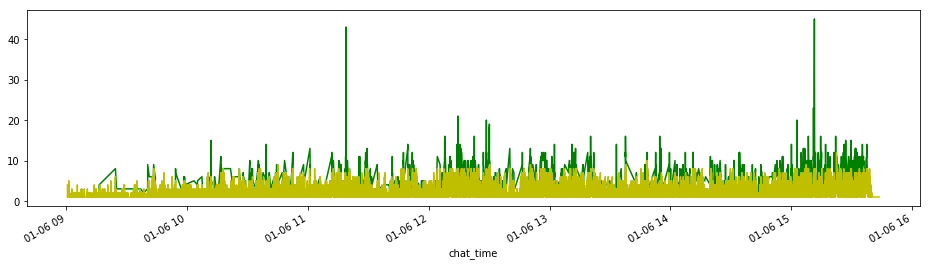

In [198]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
yes_data['cnt_chat'].plot(c='green')

no_data['cnt_chat'].plot(c='y')
plt.show()

In [199]:
yes_data[yes_data['cnt_chat'] > 20].head()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,predict
chat_time,,,,,,,
2019-01-06 11:18:53,43,21,0,0,27,0,1
2019-01-06 12:14:28,21,7,0,0,0,0,1
2019-01-06 15:11:00,23,42,0,0,0,0,1
2019-01-06 15:11:27,45,184,0,0,0,0,1


In [197]:
yes_data.index
chat_df[chat_df.index == yes_data.index[4]]

,chatterer,chat_time,chat_contents,stream_time,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
chat_time,,,,,,,,,
2019-01-06 09:24:25,<+시그프리드 (kr_siegfried)>,2019-01-06 09:24:25,지랄하네,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<안일무새 (regulus2721)>,2019-01-06 09:24:25,명,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<moon_je>,2019-01-06 09:24:25,명,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<+capthook2>,2019-01-06 09:24:25,????????,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<RedRina_>,2019-01-06 09:24:25,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,00:23:51,19,0,0,0,0
2019-01-06 09:24:25,<이무것도아닌사람 (ronie1492)>,2019-01-06 09:24:25,해,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<아마니 (kll6321)>,2019-01-06 09:24:25,유튜버임,00:23:51,0,0,0,0,0
2019-01-06 09:24:25,<흐앙렐라합방해 (1212asasqwqw4)>,2019-01-06 09:24:25,명,00:23:51,0,0,0,0,0
